In [1]:
import pandas as pd
from matplotlib import pyplot as plt
from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
import random
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer

In [2]:
seed = 0
random.seed(seed)

In [3]:
def normalize_date(date: str):
    date = date.split('/')
    if date[1].startswith('0'):
        date[1] = date[1][1:]
    if len(date[2]) == 2:
        date[2] = '20' + date[2]
    return '/'.join(date)

In [4]:
data = pd.read_csv('ci_data.csv')
# data = data.drop(data.columns[0], axis=1)
data = data.dropna()
data['Date'] = data['Date'].apply(normalize_date)
data = data.set_index('Date')
# data['Date.1'] = data.index.astype(str)
data.index = pd.to_datetime(data.index, format='%d/%m/%Y')
# data.index = pd.to_datetime(data.index, format='%Y-%m-%d')
beafore = len(data)
data = data.dropna()
print(f'Данные сокращены на {round((beafore - len(data))/beafore, 2)}% (убраны пустые значения)')
display(data.head(10))

Данные сокращены на 0.0% (убраны пустые значения)


,Category,RefNo,Date.1,Withdrawal,Deposit,Balance
Date,,,,,,
2023-01-01,Rent,3.00E+11,1/1/2023,3950.0,0.0,1837.23
2023-01-03,Misc,3.00E+11,3/1/2023,105.0,0.0,1732.23
2023-01-03,Misc,3.37E+11,3/1/2023,0.0,55.0,1787.23
2023-01-03,Food,3.00E+11,3/1/2023,56.0,0.0,1731.23
2023-01-03,Misc,3.37E+11,3/1/2023,1.0,0.0,1730.23
2023-01-03,Food,3.00E+11,3/1/2023,30.0,0.0,1700.23
2023-01-04,Misc,3.00E+11,4/1/2023,500.0,0.0,1200.23
2023-01-04,Misc,3.00E+11,4/1/2023,1.0,0.0,1199.23
2023-01-04,Misc,3.00E+11,4/1/2023,500.0,0.0,699.23


In [5]:
targets = data['Category'].unique()
print('Возможные категории:')
for target in targets:
    print(f'    - {target}: ', sum(data['Category'] == target))

Возможные категории:
    - Rent:  7
    - Misc:  505
    - Food:  912
    - Salary:  10
    - Shopping:  32
    - Transport:  3


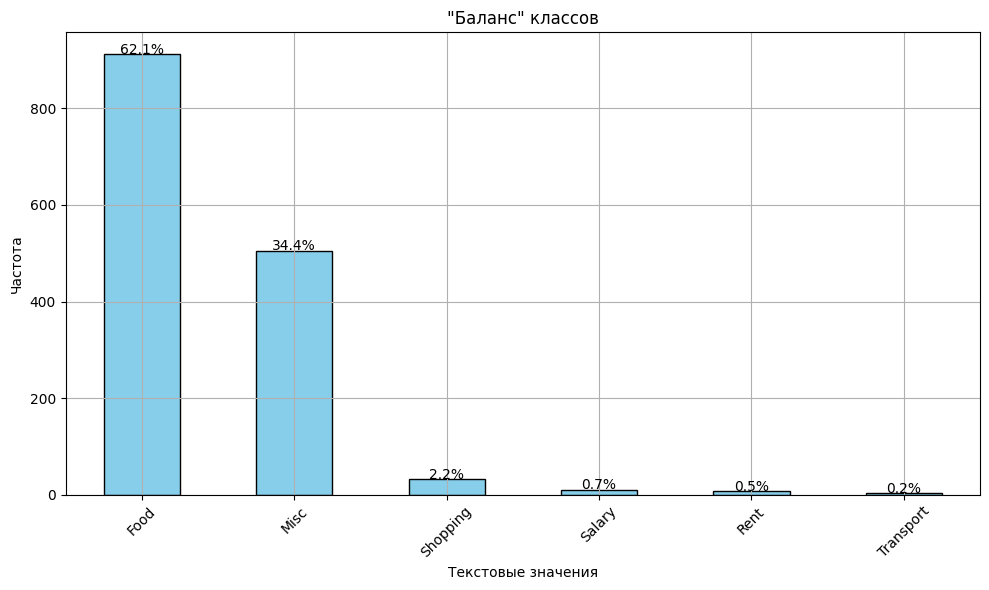

In [6]:
plt.figure(figsize=(10, 6))
data['Category'].value_counts().plot(kind='bar', color='skyblue', edgecolor='black', grid=True)
# Добавление процентов на столбцах
counts = data['Category'].value_counts()
percentages = counts / counts.sum() * 100
for i, v in enumerate(counts):
    plt.text(i, v + 1, f"{percentages.iloc[i]:.1f}%", color='black', ha='center')

# Настройка графика
plt.title('"Баланс" классов')
plt.xlabel('Текстовые значения')
plt.ylabel('Частота')
plt.xticks(rotation=45)  # Поворот меток для лучшей читаемости
plt.tight_layout()  # Правильное размещение меток
plt.show()


<Axes: title={'center': 'Изменения баланса в датасете'}, xlabel='Date', ylabel='Баланс'>

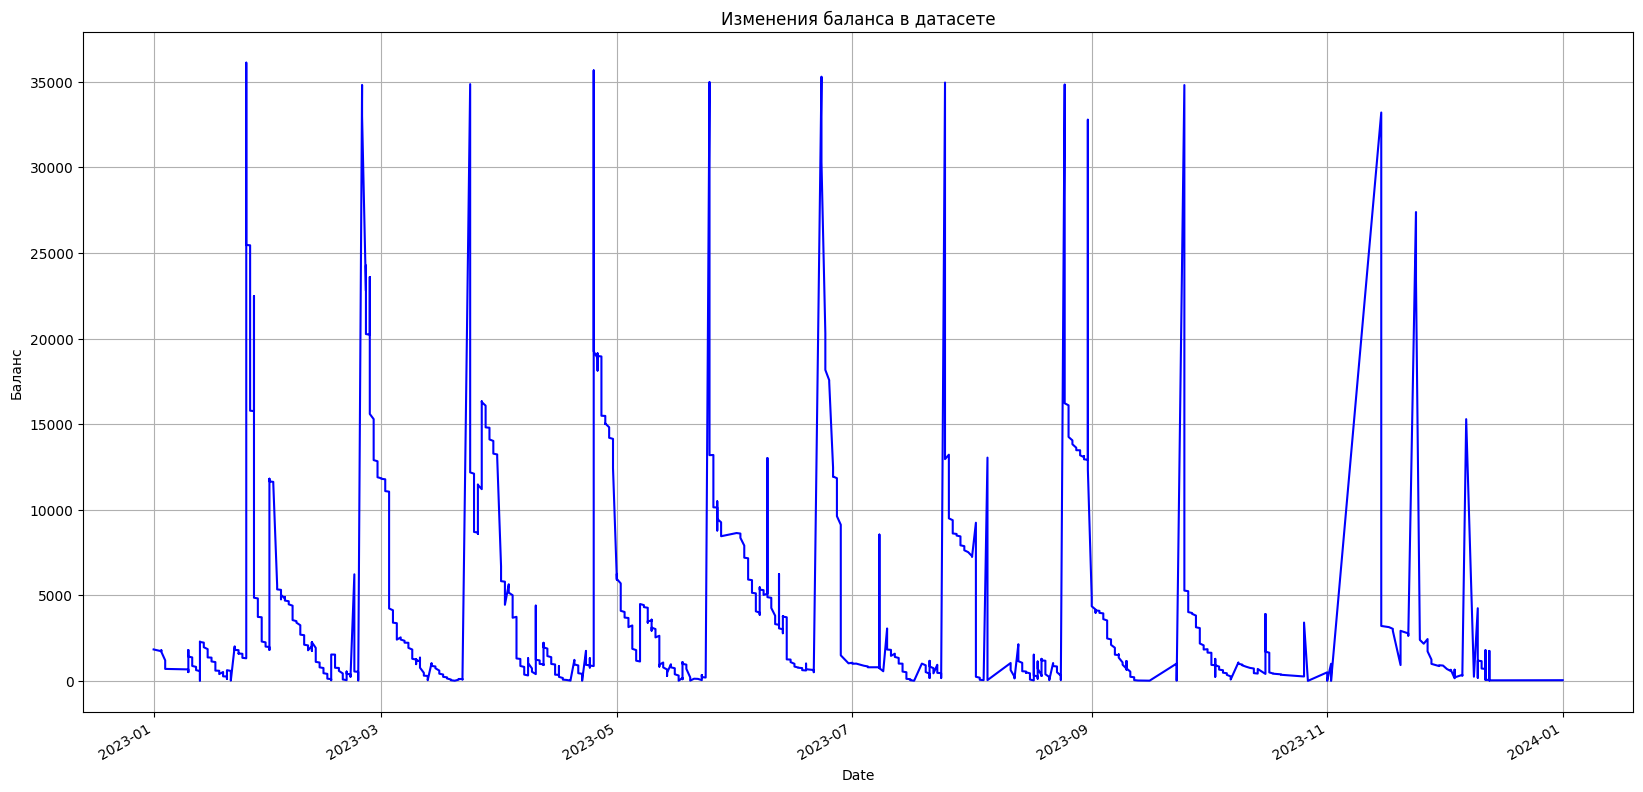

In [7]:
plt.figure(figsize=(20, 10))
plt.title('Изменения баланса в датасете')
plt.xlabel('Даты')
plt.ylabel('Баланс')
data['Balance'].plot(color='blue', grid=True)

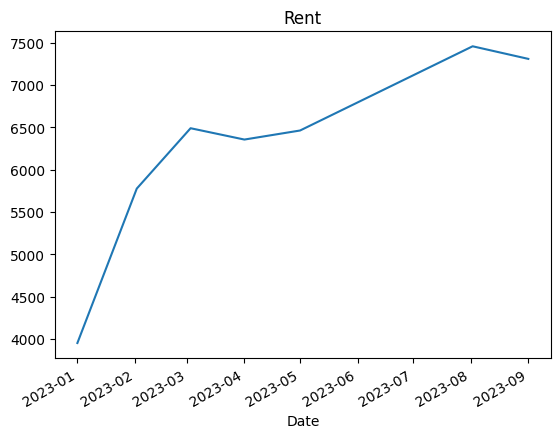

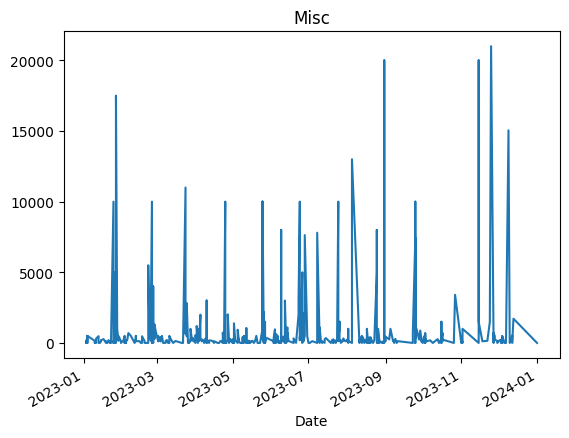

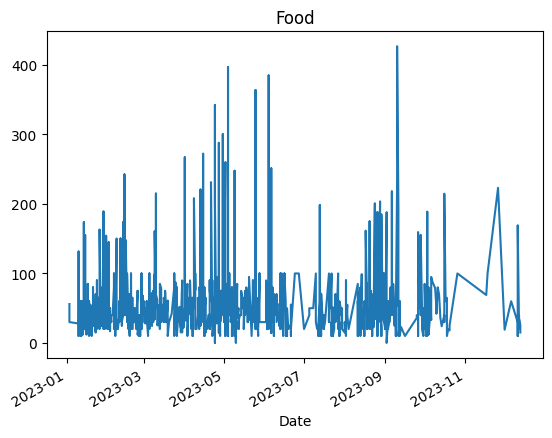

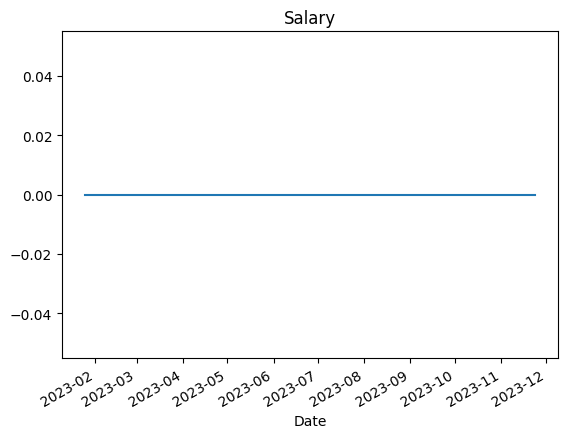

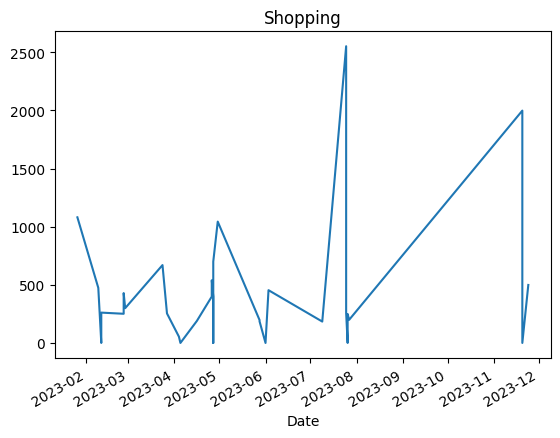

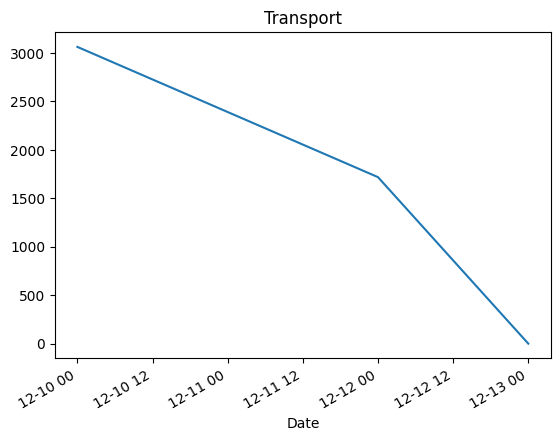

In [8]:
for target in targets:
    plt.title(target)
    data['Withdrawal'].where(data['Category'] == target).dropna().plot()
    plt.show()

In [9]:
data['day'] = data.index.day
data['month'] = data.index.month
data['weekday'] = data.index.weekday
data['weekofyear'] = data.index.isocalendar().week
data['Quarter'] = data.index.quarter

data['is_weekend'] = data.index.dayofweek.isin([5, 6])

# data['WithdrawalRollingMean'] = data['Withdrawal'].rolling(window=3).mean()

data['Transaction'] = data['Deposit'] - data['Withdrawal']
data = data.drop(labels='Deposit', axis=1)
data = data.drop(labels='Withdrawal', axis=1)

data['is_deposit'] = data['Transaction'] > 0
data['Transaction'] = data['Transaction'].abs()

In [10]:
# data = data.drop('RefNo', axis=1)
data.head(10)

,Category,RefNo,Date.1,Balance,day,month,weekday,weekofyear,Quarter,is_weekend,Transaction,is_deposit
Date,,,,,,,,,,,,
2023-01-01,Rent,3.00E+11,1/1/2023,1837.23,1,1,6,52,1,True,3950.0,False
2023-01-03,Misc,3.00E+11,3/1/2023,1732.23,3,1,1,1,1,False,105.0,False
2023-01-03,Misc,3.37E+11,3/1/2023,1787.23,3,1,1,1,1,False,55.0,True
2023-01-03,Food,3.00E+11,3/1/2023,1731.23,3,1,1,1,1,False,56.0,False
2023-01-03,Misc,3.37E+11,3/1/2023,1730.23,3,1,1,1,1,False,1.0,False
2023-01-03,Food,3.00E+11,3/1/2023,1700.23,3,1,1,1,1,False,30.0,False
2023-01-04,Misc,3.00E+11,4/1/2023,1200.23,4,1,2,1,1,False,500.0,False
2023-01-04,Misc,3.00E+11,4/1/2023,1199.23,4,1,2,1,1,False,1.0,False
2023-01-04,Misc,3.00E+11,4/1/2023,699.23,4,1,2,1,1,False,500.0,False


In [11]:
# Сбалансируем датасет, сократив преобладующие классы.

# percentage = 0.2

# # Получить уникальные классы
# classes = ['Misc', 'Food']

# # Инициализировать список для хранения данных
# data_filtered_list = []

# len_beafore = len(data)

# # Для каждого класса оставить только указанный процент строк
# for class_value in classes:
#     # Выбрать строки для текущего класса
#     class_indexes = range(len(data[data['Category'] == class_value]))

#     # Рассчитать количество строк, которое нужно оставить
#     # num_rows_to_keep = int(len(class_data) * percentage)
#     num_rows_to_keep = 10

#     # Случайно выбрать указанное количество строк
#     indices_to_remove = np.random.choice(class_indexes, len(class_indexes) - num_rows_to_keep, replace=False)

#     data = data.drop(data.index[indices_to_remove])

# data = data.dropna()
# print(f'Было сокращено {round((len_beafore - len(data))/len_beafore * 100, 2)}% датасета')

In [12]:
scaler = MinMaxScaler()
# data[['Balance', 'Transaction']] = (data[['Balance', 'Transaction']] - data[['Balance', 'Transaction']].min()) / (data[['Balance', 'Transaction']].max() - data[['Balance', 'Transaction']].min())


data[['Balance', 'Transaction']] = scaler.fit_transform(data[['Balance', 'Transaction']])

In [13]:
# data.index[pd.read_csv('trash.csv')['index']]

In [14]:
# # Удалим записи с Misc, которые в действительности можно отнести к другой категории

# delete_ind = list(pd.read_csv('trash.csv')['index'])
# print(len(delete_ind))

# data = data.reset_index()
# # data['id'] = data.index

# len_beafore = len(data)
# print(data.iloc[delete_ind])
# data = data.drop(delete_ind, axis=0)
# # data = data.where(pd.read_csv('trash.csv')['index'] not in pd.array(range(len(data))))
# data = data.dropna()

# data = data.set_index('Date')
# print(f'Данные сокращены на {beafore - len(data)} записей')

In [15]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

def train_test_split_by_class(X, y, test_size=0.2, random_state=seed):
    classes = np.unique(y)

    X_train_list = []
    X_test_list = []
    y_train_list = []
    y_test_list = []

    for class_value in classes:
        class_indices = np.where(y == class_value)[0]

        if isinstance(X, pd.DataFrame):
            X_class = X.iloc[class_indices]
        else:
            X_class = X[class_indices]

        y_class = y[class_indices]

        X_train_class, X_test_class, y_train_class, y_test_class = train_test_split(
            X_class, y_class, test_size=test_size, random_state=random_state
        )

        X_train_list.append(X_train_class)
        X_test_list.append(X_test_class)
        y_train_list.append(y_train_class)
        y_test_list.append(y_test_class)

    if isinstance(X_train_list[0], pd.DataFrame):
        X_train = pd.concat(X_train_list, ignore_index=True)
        X_test = pd.concat(X_test_list, ignore_index=True)
    else:
        X_train = np.concatenate(X_train_list, axis=0)
        X_test = np.concatenate(X_test_list, axis=0)

    y_train = np.concatenate(y_train_list, axis=0)
    y_test = np.concatenate(y_test_list, axis=0)

    return X_train, X_test, y_train, y_test


In [16]:
y = data['Category']
X = data.drop('Category', axis=1)
X = X.drop('RefNo', axis=1)

# X = X.where(data['Category'] != 'Misc')
X = X.dropna()

# y = y.where(data['Category'] != 'Misc')
y = y.dropna()
print(len(y))

X_train, X_test, y_train, y_test = train_test_split_by_class(X, y, test_size=0.3, random_state=seed)

1469


C:\Users\Micha\AppData\Local\Temp\ipykernel_2856\1564413559.py:21: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_class = y[class_indices]


In [17]:
# import optuna
# from catboost import CatBoostClassifier

# def objective(trial):
#     model = CatBoostClassifier(
#         iterations=trial.suggest_int('iterations', 500, 4000, step=100),
#         learning_rate=trial.suggest_loguniform('learning_rate', 5e-3,5e-1),
#         depth=trial.suggest_int('depth', 2, 8),
#         l2_leaf_reg=trial.suggest_uniform('l2_leaf_reg', 1, 10),
#         verbose=0, cat_features=('Date.1', 'is_weekend', 'is_deposit'),
#         auto_class_weights='Balanced',
#         # has_time=True,
#     )
#     model.fit(X_train, y_train, eval_set=(X_test, y_test))
    
#     return f1_score(y_test, model.predict(X_test), average='macro')

# study = optuna.create_study(direction='maximize')
# study.optimize(objective, n_trials=100, n_jobs=-1, show_progress_bar=True)


In [18]:
# print(study.best_params)
# model = CatBoostClassifier(**study.best_params, auto_class_weights='Balanced', cat_features=('Date.1', 'is_weekend', 'is_deposit'))
model = CatBoostClassifier(iterations = 3200, learning_rate = 0.010194516790832045, depth=3, l2_leaf_reg = 3.0779258993168606, auto_class_weights='Balanced', cat_features=('Date.1', 'is_weekend', 'is_deposit'))

In [ ]:
# model.fit(X_train[y_train != 'Misc'], y_train[y_train != 'Misc'])
# model.fit(X_train, y_train)

model = model.fit(X_train, y_train)

# # train_pool = Pool(data=X_train, label=y_train)
# train_pool = Pool(data=X_train[y_train != 'Misc'].dropna(), label=y_train[y_train != 'Misc'], cat_features=('Date.1', 'is_weekend', 'is_deposit'))

# # test_pool = Pool(data=X_test, label=y_test, cat_features=('Date.1', 'is_weekend', 'is_deposit'))
# test_pool = Pool(data=X_test[y_test != 'Misc'].dropna(), label=y_test[y_test != 'Misc'], cat_features=('Date.1', 'is_weekend', 'is_deposit'))

# model.fit(train_pool, eval_set=test_pool)

0:	learn: 1.7701725	total: 162ms	remaining: 8m 39s
1:	learn: 1.7562586	total: 177ms	remaining: 4m 42s
2:	learn: 1.7458200	total: 196ms	remaining: 3m 28s
3:	learn: 1.7306478	total: 209ms	remaining: 2m 46s
4:	learn: 1.7193113	total: 225ms	remaining: 2m 24s
5:	learn: 1.7019682	total: 243ms	remaining: 2m 9s
6:	learn: 1.6849254	total: 262ms	remaining: 1m 59s
7:	learn: 1.6765307	total: 281ms	remaining: 1m 52s
8:	learn: 1.6582798	total: 301ms	remaining: 1m 46s
9:	learn: 1.6511887	total: 320ms	remaining: 1m 42s
10:	learn: 1.6455172	total: 340ms	remaining: 1m 38s
11:	learn: 1.6336085	total: 359ms	remaining: 1m 35s
12:	learn: 1.6221590	total: 378ms	remaining: 1m 32s
13:	learn: 1.6141566	total: 396ms	remaining: 1m 30s
14:	learn: 1.6087563	total: 410ms	remaining: 1m 27s
15:	learn: 1.5960589	total: 428ms	remaining: 1m 25s
16:	learn: 1.5956665	total: 440ms	remaining: 1m 22s
17:	learn: 1.5900129	total: 459ms	remaining: 1m 21s
18:	learn: 1.5888904	total: 475ms	remaining: 1m 19s
19:	learn: 1.5834555	to

In [ ]:
# Оценка производительности модели
accuracy = model.score(X_test, y_test)
print(f"Accuracy: {accuracy}")

Accuracy: 0.9413092550790068


In [ ]:
model.save_model('model_tb.cbm')

In [ ]:
y_pred = model.predict(X_test)

f1_macro = f1_score(y_test, y_pred, average='macro')
print(f"Macro F1 Score: {f1_macro}")

Macro F1 Score: 0.6960340465900706


In [ ]:
probabilities = model.predict_proba(X_test)

indices = np.argmax(probabilities, axis=1)
max_probabilities = np.max(probabilities, axis=1)

# Решения, у которых вероятность >= 0.7
# for i in range(100):
    # print(i)
mask = max_probabilities < .96

y_pred = model.classes_[indices]
y_pred = np.where(mask, 'Misc', y_pred)

f1_macro = f1_score(y_test, y_pred, average='macro')
print(f"Macro F1 Score: {f1_macro}")

Macro F1 Score: 0.7144530868861442


In [ ]:
display(X)

,Date.1,Balance,day,month,weekday,weekofyear,Quarter,is_weekend,Transaction,is_deposit
Date,,,,,,,,,,
2023-01-01,1/1/2023,0.050861,1,1,6,52,1,True,0.113480,False
2023-01-03,3/1/2023,0.047954,3,1,1,1,1,False,0.002989,False
2023-01-03,3/1/2023,0.049477,3,1,1,1,1,False,0.001552,True
2023-01-03,3/1/2023,0.047926,3,1,1,1,1,False,0.001581,False
2023-01-03,3/1/2023,0.047899,3,1,1,1,1,False,0.000000,False
...,...,...,...,...,...,...,...,...,...,...
2023-12-13,13/12/23,0.001288,13,12,2,50,4,False,0.000718,False
2023-12-13,13/12/23,0.000873,13,12,2,50,4,False,0.000402,False
2023-12-13,13/12/23,0.048437,13,12,2,50,4,False,0.049340,True


In [ ]:
misk_probs = []
for_delete = []
fine_probs = []
right_answers = []

a = []
b = []



for i, prob in enumerate(probabilities):
    print(f"Экземпляр {i+1}:")

    for j, p in enumerate(prob):
        print(f"  Класс {model.classes_[j]}: {p}")
    print(y[i], '\n')

    max_ = prob.max()
    ind_ = list(prob).index(max_)

    prob = np.delete(prob, ind_)
    max_2 = prob.max()
    prob = np.array((max_, max_2))

    # mean = np.mean(prob)
    # std_dev = np.std(prob)
    # z_scores = np.abs((prob - mean) / std_dev)
    # print(round((max_ - max_2)/max_, 2))
    koef = round((max_ - max_2)/max_, 2)

    if y[i-1] == model.classes_[ind_]:
        a.append(koef)
    elif y[i-1] == 'Misc':
        b.append(koef)

    if y[i-1] == 'Misc':
        misk_probs.append(max_)
        if max_ > 0.9:
            for_delete.append(i-1)
    elif y[i-1] == model.classes_[ind_]:
        fine_probs.append(max_)
        right_answers.append((max_, model.classes_[ind_]))

Экземпляр 1:
  Класс Food: 0.999783744685197
  Класс Misc: 0.0002159898508124681
  Класс Rent: 1.4376606049479298e-08
  Класс Salary: 6.1495468880638995e-09
  Класс Shopping: 2.224258976670127e-07
  Класс Transport: 2.251193982008528e-08
Rent 

Экземпляр 2:
  Класс Food: 0.9951117616343472
  Класс Misc: 0.004855638968260901
  Класс Rent: 8.302341744180388e-08
  Класс Salary: 3.59032665815515e-07
  Класс Shopping: 3.201501856682359e-05
  Класс Transport: 1.4232274205904316e-07
Misc 

Экземпляр 3:
  Класс Food: 0.9988219366927328
  Класс Misc: 0.0011146114351433983
  Класс Rent: 3.2788940974893984e-07
  Класс Salary: 2.49704853737645e-07
  Класс Shopping: 6.250410083896655e-05
  Класс Transport: 3.7017702148524997e-07
Misc 

Экземпляр 4:
  Класс Food: 0.9986112033091878
  Класс Misc: 0.0013866467378222905
  Класс Rent: 1.1506005456531693e-07
  Класс Salary: 1.0585341039076637e-07
  Класс Shopping: 1.1565113783169195e-06
  Класс Transport: 7.725281465920731e-07
Food 

Экземпляр 5:
  Класс

C:\Users\Micha\AppData\Local\Temp\ipykernel_9852\2537599871.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(y[i], '\n')
C:\Users\Micha\AppData\Local\Temp\ipykernel_9852\2537599871.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if y[i-1] == model.classes_[ind_]:
C:\Users\Micha\AppData\Local\Temp\ipykernel_9852\2537599871.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elif y[i-1] == 'Misc':
C:\Users\Micha\AppDat

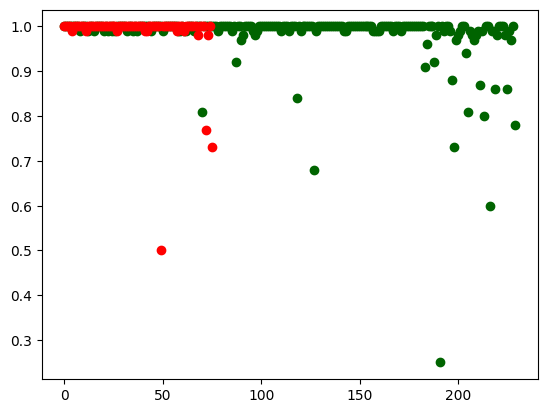

In [ ]:
plt.plot(a, color='darkgreen', marker='o', linestyle='None')
plt.plot(b, color='red', marker='o', linestyle='None')

In [ ]:
# pd.DataFrame({'index': for_delete}).to_csv('trash.csv')
# print(f'Из категории "Другое" нужно удалить {len(for_delete)} экземпляров')

In [ ]:
# Уровень уверенности модели в своём решении, когда оно оказалось верным

sorted(right_answers)

[(0.5725476546267124, 'Food'),
 (0.7425559182671887, 'Food'),
 (0.8124948191726098, 'Food'),
 (0.9736136963233383, 'Food'),
 (0.9814980363469638, 'Food'),
 (0.9833971952955138, 'Food'),
 (0.988180653609536, 'Food'),
 (0.9889568993337164, 'Food'),
 (0.9889990450013608, 'Food'),
 (0.9895436143785169, 'Food'),
 (0.9904909258785987, 'Food'),
 (0.9905611533837854, 'Food'),
 (0.9916546341332122, 'Food'),
 (0.9917045687670861, 'Food'),
 (0.9925184835508996, 'Food'),
 (0.9926024490042671, 'Food'),
 (0.9926740616897126, 'Food'),
 (0.992888814208563, 'Food'),
 (0.9929372456833147, 'Food'),
 (0.9931178200334176, 'Food'),
 (0.9931783231325596, 'Food'),
 (0.9932503776610798, 'Food'),
 (0.9932989418914419, 'Food'),
 (0.9934322160206381, 'Food'),
 (0.9937247446986026, 'Food'),
 (0.9941406585692968, 'Food'),
 (0.9941891845019561, 'Food'),
 (0.9943189332296722, 'Food'),
 (0.9944280541672891, 'Food'),
 (0.9944726844021836, 'Food'),
 (0.9945003783548816, 'Food'),
 (0.9945416487833174, 'Food'),
 (0.994656

In [ ]:
print(set(y_pred))

{'Salary', 'Misc', 'Food', 'Rent'}


Минимальная уверенность в праильном решении: 0.5725476546267124


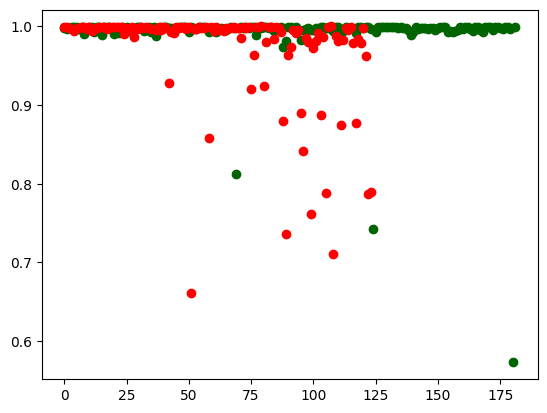

In [ ]:
plt.plot(fine_probs, color='darkgreen', marker='o', linestyle='None')
plt.plot(misk_probs, color='red', marker='o', linestyle='None')
print('Минимальная уверенность в праильном решении:', min(fine_probs))

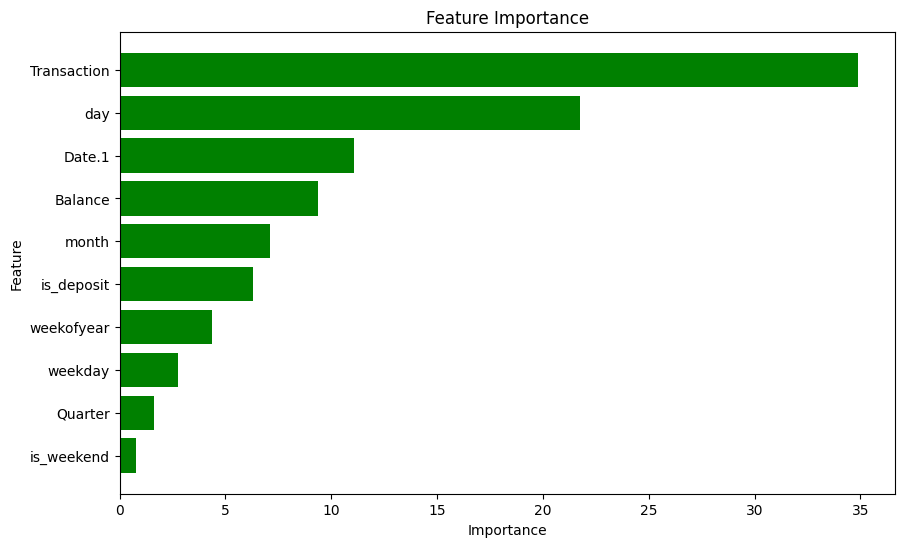

In [ ]:
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': model.feature_importances_
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='green')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.gca().invert_yaxis()
plt.show()